<a href="https://colab.research.google.com/github/ham952/ViT/blob/main/ViT_embeddings_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt

### Parameters

In [2]:
BATCH_SIZE = 512
EPOCHS = 20 # Try increasing epochs to 30
LEARNING_RATE = 3e-4
PATCH_SIZE = 4  # P
NUM_CLASSES = 10  # CIFAR-10
IMAGE_SIZE = 32 # Transform the image and make the size go to 224
CHANNELS = 3
EMBED_DIM = 256 # or 512 # E
NUM_HEADS = 8 # INcrease the number heads
DEPTH = 6 # transformer blocks
MLP_DIM = 512
DROP_RATE = 0.1
# num_patches = (IMAGE_SIZE // PATCH_SIZE) ** 2 : 64 # N
# x shape: torch.Size([512, 3, 32, 32])

### Dataset

In [3]:
# Define transformations
train_transform = transforms.Compose([
    transforms.RandomRotation(15),  # Random rotation for training data
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
train_dataset = datasets.CIFAR10(root="data",
                                 train= True,
                                 download=True,
                                 transform=train_transform)

val_dataset = datasets.CIFAR10(root="data",
                                 train= True,
                                 download=True,
                                 transform=val_test_transform)

test_dataset = datasets.CIFAR10(root="data",
                                 train= False,
                                 download=True,
                                 transform=val_test_transform)

100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


In [5]:
train_dataset = Subset(train_dataset, range(40000))
val_dataset = Subset(val_dataset, range(40000, len(val_dataset)))

In [6]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            drop_last=True,
                            shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

In [7]:
# Let's check out what we've created
print(f"Length of train_loader: {len(train_loader)} batches of {BATCH_SIZE}...")
print(f"Length of val_loader: {len(val_loader)} batches of {BATCH_SIZE}...")
print(f"Length of test_loader: {len(test_loader)} batches of {BATCH_SIZE}...")

num_epochs = 1
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        if batch_idx >= 3:
            break
        print(" Batch index:", batch_idx, end="")
        print(" | Batch size:", y.shape[0], end="")
        print(" | x shape:", x.shape, end="")
        print(" | y shape:", y.shape)

# print("Labels from current batch:", y)

Length of train_loader: 78 batches of 512...
Length of val_loader: 19 batches of 512...
Length of test_loader: 20 batches of 512...
 Batch index: 0 | Batch size: 512 | x shape: torch.Size([512, 3, 32, 32]) | y shape: torch.Size([512])
 Batch index: 1 | Batch size: 512 | x shape: torch.Size([512, 3, 32, 32]) | y shape: torch.Size([512])
 Batch index: 2 | Batch size: 512 | x shape: torch.Size([512, 3, 32, 32]) | y shape: torch.Size([512])


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Loading Embeddings

In [9]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                img_size,
                patch_size,
                in_channels,
                embed_dim):
      super().__init__()

      self.patch_size = patch_size
      self.proj = nn.Conv2d(in_channels= in_channels,
                            out_channels= embed_dim,
                            kernel_size=patch_size,
                            stride = patch_size)
      num_patches = (img_size // patch_size) ** 2
      self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim), requires_grad=True) # Classification Token
      self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim), requires_grad= True) # 1, N+1, E
      self.dropout = nn.Dropout(p=0.1)

    def forward(self, x:torch.Tensor):
      B = x.size(0)
      x = self.proj(x)  # B, C, IH, IW     --> B, E, IH/P, IW/P                Split image into the patches and embed patches
      x = x.flatten(2).transpose(1, 2) # B, E, IH/P, IW/P --> B, E, (IH/P*IW/P) --> B, E, N --> B, N, E
      cls_tokens = self.cls_token.expand(B, -1, -1) # 1, 1, E --> B, 1, E
      x = torch.cat([cls_tokens, x], dim=1) # B, N+1, E i.e., [512, 65, 256]
      x = x + self.pos_embed # [B, N+1, E] +  [1, N+1, E]
      x = self.dropout(x)
      return x


In [10]:
class MLP(nn.Module):
    def __init__(self,
                 in_features,
                 hidden_features,
                 drop_rate):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_features,
                             out_features=hidden_features)
        self.fc2 = nn.Linear(in_features=hidden_features,
                             out_features=in_features)
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, x):
        x = self.dropout(F.gelu(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        return x

In [11]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=drop_rate, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_dim, drop_rate)

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0] # query, key, value # returns tuple (output, attn_weights)[0]
                                                                          # output = (batch_size, seq_len, embed_dim)
                                                                          # attn_weights = (batch_size, num_heads, seq_len, seq_len)

        x = x + self.mlp(self.norm2(x))
        return x

In [12]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, num_classes,
                 embed_dim, depth, num_heads, mlp_dim, drop_rate,
                 use_identity_head=False, use_identity_norm=False):
        super().__init__()

        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)

        self.encoder = nn.Sequential(*[
            TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate)
            for _ in range(depth)
        ])

        self.norm = nn.Identity() if use_identity_norm else nn.LayerNorm(embed_dim)
        self.head = nn.Identity() if use_identity_head else nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)       # B, N+1, E
        x = self.encoder(x)           # B, N+1, E
        x = self.norm(x)              # B, N+1, E
        cls_token = x[:, 0]           # B, E
        x = self.head(cls_token)      # B, num_classes OR B, embed_dim
        return x


In [ ]:
model = VisionTransformer(
    img_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    in_channels=CHANNELS,
    num_classes=NUM_CLASSES,       # unused if head is Identity
    embed_dim=256,
    depth=6,
    num_heads=NUM_HEADS,
    mlp_dim=MLP_DIM,
    drop_rate=DROP_RATE,
    use_identity_head=True,
    use_identity_norm=True
).to(device)

In [20]:
model.load_state_dict(torch.load("vit_embeddings_weights.pth", map_location=device))
model

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-

In [24]:
# Test

state = model.load_state_dict(torch.load("vit_embeddings_weights.pth", map_location=device))
print("Missing keys:", state.missing_keys)
print("Unexpected keys:", state.unexpected_keys)

model.eval()
with torch.no_grad():
    dummy_input = torch.randn(512, 3, 32, 32).to(device)
    output = model(dummy_input)
    print("Output shape:", output.shape)

Missing keys: []
Unexpected keys: []
Output shape: torch.Size([512, 256])


## Baseline Model

In [25]:
pytorch_model = torch.hub.load('pytorch/vision', 'resnet18', weights=None)

Downloading: "https://github.com/pytorch/vision/zipball/main" to /root/.cache/torch/hub/main.zip


In [27]:
# Modify the classifier head for CIFAR-10 (10 classes)
pytorch_model.fc = torch.nn.Linear(pytorch_model.fc.in_features, 10)
pytorch_model = pytorch_model.to(device)
pytorch_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pytorch_model.parameters(), lr=1e-3)

In [29]:
EPOCHS = 10

for epoch in range(EPOCHS):
    pytorch_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = pytorch_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"Epoch {epoch+1}, Loss: {running_loss/total:.4f}, Accuracy: {acc:.4f}")

Epoch 1, Loss: 1.5391, Accuracy: 0.4442
Epoch 2, Loss: 1.1858, Accuracy: 0.5730
Epoch 3, Loss: 1.0229, Accuracy: 0.6362
Epoch 4, Loss: 0.9122, Accuracy: 0.6756
Epoch 5, Loss: 0.8046, Accuracy: 0.7165
Epoch 6, Loss: 0.7255, Accuracy: 0.7448
Epoch 7, Loss: 0.6605, Accuracy: 0.7661
Epoch 8, Loss: 0.6024, Accuracy: 0.7856
Epoch 9, Loss: 0.5520, Accuracy: 0.8026
Epoch 10, Loss: 0.4908, Accuracy: 0.8258


In [30]:
def evaluate(model, dataloader, device):
    model.eval()  # set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # no gradient computation needed
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # raw logits
            predictions = outputs.argmax(dim=1)  # predicted class indices
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy


In [31]:
test_accuracy = evaluate(pytorch_model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.6960


In [32]:
def predict_and_plot_grid(model,
                          dataset,
                          classes,
                          grid_size=3):
    model.eval()
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(9, 9))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = random.randint(0, len(dataset) - 1)
            img, true_label = dataset[idx]
            input_tensor = img.unsqueeze(dim=0).to(device)
            with torch.inference_mode():
                output = model(input_tensor)
                _, predicted = torch.max(output.data, 1)
            img = img / 2 + 0.5 # Unormalize our images to be able to plot them with matplotlib
            npimg = img.cpu().numpy()
            axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
            truth = classes[true_label] == classes[predicted.item()]
            if truth:
                color = "g"
            else:
                color = "r"

            axes[i, j].set_title(f"Truth: {classes[true_label]}\n, Predicted: {classes[predicted.item()]}", fontsize=10, c=color)
            axes[i, j].axis("off")
    plt.tight_layout()
    plt.show()

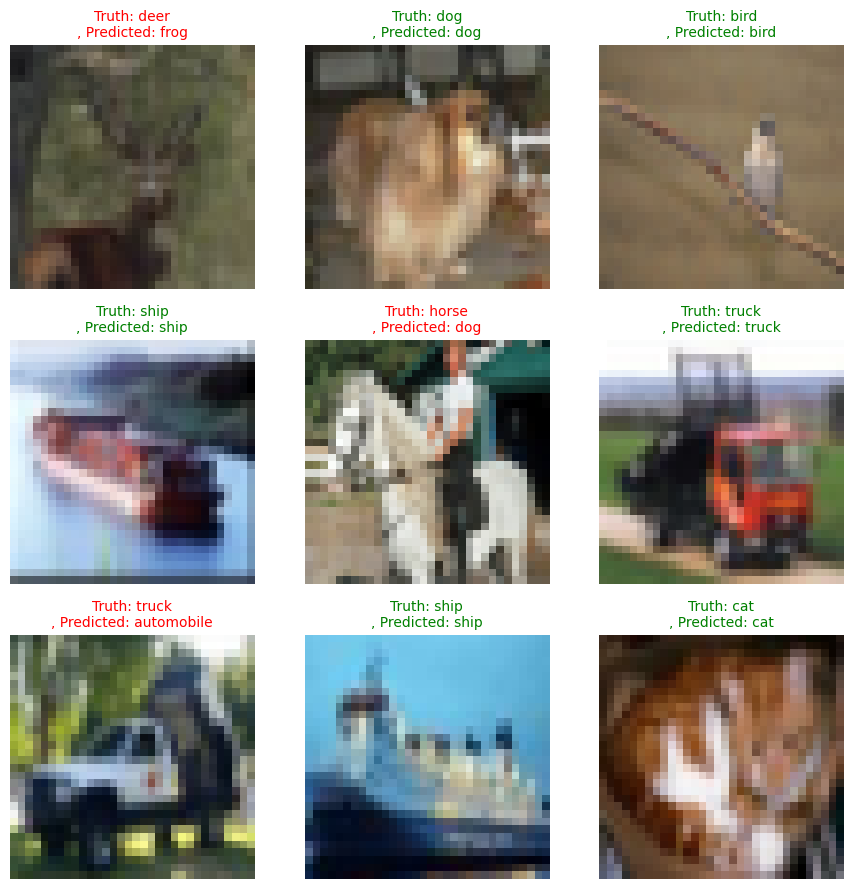

In [34]:
predict_and_plot_grid(model=pytorch_model,
                      dataset=test_dataset,
                      classes=test_dataset.classes,
                      grid_size=3)

## Embeddings Performance

##1. Create Base Model

In [52]:
import torch.nn as nn

class BaseModel(nn.Module):
    def __init__(self, input_dim=256, num_classes=10):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

In [53]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=100, print_every=10):
    for epoch in range(epochs):
        # Training phase
        model.train()
        total_loss, correct, total = 0, 0, 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size(0)
            correct += (outputs.argmax(1) == y).sum().item()
            total += y.size(0)

        train_acc = correct / total
        train_loss = total_loss / total

        # Validation phase
        model.eval()
        val_correct, val_total, val_loss = 0, 0, 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                val_outputs = model(x_val)
                val_loss += criterion(val_outputs, y_val).item() * x_val.size(0)
                val_correct += (val_outputs.argmax(1) == y_val).sum().item()
                val_total += y_val.size(0)

        val_acc = val_correct / val_total
        val_loss = val_loss / val_total

        # Print every N epochs
        if (epoch + 1) % print_every == 0 or (epoch + 1) == epochs:
            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | "
                  f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


In [57]:
def evaluate(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

## 2. Test on raw images data

In [59]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Updated normalization for 3-channel CIFAR-10 (standard for image models)
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

# Flattened transform for raw image MLP
train_transform_flat = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten to [3072]
])

val_test_transform_flat = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten to [3072]
])

# Load CIFAR-10 with flatten transforms
raw_train_dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=train_transform_flat)
raw_val_dataset   = datasets.CIFAR10(root="data", train=True, download=True, transform=val_test_transform_flat)
raw_test_dataset  = datasets.CIFAR10(root="data", train=False, download=True, transform=val_test_transform_flat)

# Split into 40k train and 10k val (same as before)
raw_train_dataset = Subset(raw_train_dataset, range(40000))
raw_val_dataset   = Subset(raw_val_dataset, range(40000, len(raw_val_dataset)))

# DataLoaders
raw_train_loader = DataLoader(dataset=raw_train_dataset, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)
raw_val_loader   = DataLoader(dataset=raw_val_dataset, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)
raw_test_loader  = DataLoader(dataset=raw_test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [62]:
model_raw = BaseModel(input_dim=3072, num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_raw.parameters(), lr=1e-3)

In [65]:
train_model(
    model=model_raw,
    train_loader=raw_train_loader,
    val_loader=raw_val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    epochs=10,
    print_every=1
)

Epoch 1/10 | Train Acc: 0.4931 | Val Acc: 0.5024 | Train Loss: 1.4492 | Val Loss: 1.4424
Epoch 2/10 | Train Acc: 0.4958 | Val Acc: 0.4996 | Train Loss: 1.4362 | Val Loss: 1.4257
Epoch 3/10 | Train Acc: 0.5002 | Val Acc: 0.5065 | Train Loss: 1.4309 | Val Loss: 1.4161
Epoch 4/10 | Train Acc: 0.4978 | Val Acc: 0.5153 | Train Loss: 1.4315 | Val Loss: 1.4018
Epoch 5/10 | Train Acc: 0.4989 | Val Acc: 0.5098 | Train Loss: 1.4266 | Val Loss: 1.4169
Epoch 6/10 | Train Acc: 0.5052 | Val Acc: 0.5101 | Train Loss: 1.4166 | Val Loss: 1.4077
Epoch 7/10 | Train Acc: 0.5080 | Val Acc: 0.5166 | Train Loss: 1.4100 | Val Loss: 1.4076
Epoch 8/10 | Train Acc: 0.5105 | Val Acc: 0.5149 | Train Loss: 1.4000 | Val Loss: 1.3979
Epoch 9/10 | Train Acc: 0.5093 | Val Acc: 0.5161 | Train Loss: 1.4060 | Val Loss: 1.3980
Epoch 10/10 | Train Acc: 0.5092 | Val Acc: 0.5190 | Train Loss: 1.4016 | Val Loss: 1.3982


In [ ]:
test_acc = evaluate(model, raw_test_loader)
print(f"✅ Final Test Accuracy: {test_acc:.4f}")

###3. Generate Embeddings for dataloaders

In [35]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Helper function to extract embeddings from a dataloader
def generate_embeddings(model, dataloader):
    model.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            embeddings = model(x)  # shape: [B, 256]
            all_embeddings.append(embeddings.cpu())
            all_labels.append(y)

    # Combine batches
    all_embeddings = torch.cat(all_embeddings)
    all_labels = torch.cat(all_labels)
    return all_embeddings, all_labels


In [41]:
train_embs, train_lbls = generate_embeddings(model, train_loader)
val_embs, val_lbls     = generate_embeddings(model, val_loader)
test_embs, test_lbls   = generate_embeddings(model, test_loader)

BATCH_SIZE = 512

train_embed_dataset = TensorDataset(train_embs, train_lbls)
val_embed_dataset   = TensorDataset(val_embs, val_lbls)
test_embed_dataset  = TensorDataset(test_embs, test_lbls)

train_embed_loader = DataLoader(train_embed_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_embed_loader   = DataLoader(val_embed_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_embed_loader  = DataLoader(test_embed_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [42]:
print(f"Length of train_embed_loader: {len(train_embed_loader)} batches of {BATCH_SIZE}...")
print(f"Length of val_embed_loader: {len(val_embed_loader)} batches of {BATCH_SIZE}...")
print(f"Length of test_embed_loader: {len(test_embed_loader)} batches of {BATCH_SIZE}...")

num_epochs = 1
for epoch in range(num_epochs):
    for batch_idx, (x, y) in enumerate(train_embed_loader):
        if batch_idx >= 3:
            break
        print(" Batch index:", batch_idx, end="")
        print(" | Batch size:", y.shape[0], end="")
        print(" | x shape:", x.shape, end="")
        print(" | y shape:", y.shape)


Length of train_embed_loader: 78 batches of 512...
Length of val_embed_loader: 19 batches of 512...
Length of test_embed_loader: 20 batches of 512...
 Batch index: 0 | Batch size: 512 | x shape: torch.Size([512, 256]) | y shape: torch.Size([512])
 Batch index: 1 | Batch size: 512 | x shape: torch.Size([512, 256]) | y shape: torch.Size([512])
 Batch index: 2 | Batch size: 512 | x shape: torch.Size([512, 256]) | y shape: torch.Size([512])


## 4. Train model on embeddings

In [54]:
model_emb = BaseModel(input_dim=256, num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_emb.parameters(), lr=1e-3)

In [56]:
train_model(
    model=model_emb,
    train_loader=train_embed_loader,
    val_loader=val_embed_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    epochs=100,
    print_every=10
)

Epoch 10/100 | Train Acc: 0.8472 | Val Acc: 0.6597 | Train Loss: 0.4459 | Val Loss: 1.1876
Epoch 20/100 | Train Acc: 0.8605 | Val Acc: 0.6581 | Train Loss: 0.4084 | Val Loss: 1.2649
Epoch 30/100 | Train Acc: 0.8693 | Val Acc: 0.6553 | Train Loss: 0.3792 | Val Loss: 1.3384
Epoch 40/100 | Train Acc: 0.8777 | Val Acc: 0.6591 | Train Loss: 0.3536 | Val Loss: 1.4271
Epoch 50/100 | Train Acc: 0.8826 | Val Acc: 0.6533 | Train Loss: 0.3324 | Val Loss: 1.5173
Epoch 60/100 | Train Acc: 0.8918 | Val Acc: 0.6471 | Train Loss: 0.3082 | Val Loss: 1.5959
Epoch 70/100 | Train Acc: 0.8956 | Val Acc: 0.6522 | Train Loss: 0.2929 | Val Loss: 1.6861
Epoch 80/100 | Train Acc: 0.8997 | Val Acc: 0.6506 | Train Loss: 0.2792 | Val Loss: 1.7904
Epoch 90/100 | Train Acc: 0.9038 | Val Acc: 0.6478 | Train Loss: 0.2653 | Val Loss: 1.8913
Epoch 100/100 | Train Acc: 0.9078 | Val Acc: 0.6494 | Train Loss: 0.2555 | Val Loss: 1.9903


In [58]:
test_acc = evaluate(model, test_embed_loader)
print(f"✅ Final Test Accuracy: {test_acc:.4f}")


✅ Final Test Accuracy: 0.6473


## Trying on resnet

In [6]:
resnet = torch.hub.load('pytorch/vision', 'resnet18', weights=None)
resnet

Using cache found in /root/.cache/torch/hub/pytorch_vision_main


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
# Replace the first conv and avgpool with identity since embeddings skip CNN part
resnet.conv1 = nn.Identity()
resnet.bn1 = nn.Identity()
resnet.relu = nn.Identity()
resnet.maxpool = nn.Identity()
resnet.layer1 = nn.Identity()
resnet.layer2 = nn.Identity()
resnet.layer3 = nn.Identity()
resnet.layer4 = nn.Identity()
resnet.avgpool = nn.Identity()

# Replace fc layer with classifier for 256-D embeddings
resnet.fc = nn.Sequential(
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 10)
)

model = resnet.to(device)
model

ResNet(
  (conv1): Identity()
  (bn1): Identity()
  (relu): Identity()
  (maxpool): Identity()
  (layer1): Identity()
  (layer2): Identity()
  (layer3): Identity()
  (layer4): Identity()
  (avgpool): Identity()
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)